Importamos los archivos:

In [1]:
import pandas as pd
import numpy as np
metadata = pd.read_csv("HAM10000_metadata.csv")
ds_images = pd.read_csv("hmnist_28_28_RGB_L.csv")

In [2]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
print(metadata.shape)
print(ds_images.shape)

(10015, 7)
(10015, 2353)


In [4]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [5]:
ds_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Columns: 2353 entries, pixel0000 to label
dtypes: int64(2353)
memory usage: 179.8 MB


Completo los valores faltantes de la columna "age" con la media:

In [6]:
metadata["age"] = metadata["age"].fillna(metadata["age"].mean())

In [7]:
metadata.nunique()

,0
lesion_id,7470
image_id,10015
dx,7
dx_type,4
age,19
sex,3
localization,15


Hay 7470 lesiones para 10015 imágenes, este hecho es muy importante ya que no podemos hacer un simple train_test_split, debido a que podrían dividirse imágenes de una misma lesión, siendo un pipeline incorrecto. Para evitarlo, hay que dividir el dataset por grupos de lesiones.

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


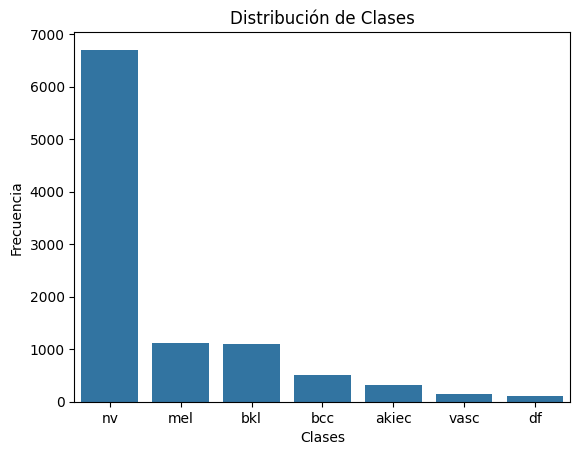

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=metadata, x='dx', order=metadata['dx'].value_counts().index)
plt.title('Distribución de Clases')
plt.xlabel('Clases')
plt.ylabel('Frecuencia')

print(metadata['dx'].value_counts())

Se observa un claro desbalanceo de clases que trataremos de paliar, ya que si no el modelo se sobreajustará a la clase mayoritaria.

Codifico las variables categóricas:

In [9]:
columns_to_encode = ['sex', 'dx_type', 'localization']
metadata = pd.get_dummies(metadata, columns=columns_to_encode)

Hago el train/test/val split en función de las lesiones, para evitar data leakage

In [10]:
lesiones_unicas = metadata['lesion_id'].unique()

np.random.seed(0)
np.random.shuffle(lesiones_unicas)

In [11]:
corte_train = int(len(lesiones_unicas) * 0.65)
corte_val = int(len(lesiones_unicas) * 0.8)

train_ids = lesiones_unicas[0:corte_train]
val_ids = lesiones_unicas[corte_train:corte_val]
test_ids = lesiones_unicas[corte_val:]

print(f"Train: {len(train_ids)} | Val: {len(val_ids)} | Test: {len(test_ids)}")

Train: 4855 | Val: 1121 | Test: 1494


In [12]:
x_train_tab = metadata[metadata['lesion_id'].isin(train_ids)]
x_val_tab = metadata[metadata['lesion_id'].isin(val_ids)]
x_test_tab = metadata[metadata['lesion_id'].isin(test_ids)]

In [13]:
print(x_train_tab.shape)
print(x_val_tab.shape)
print(x_test_tab.shape)

(6507, 26)
(1518, 26)
(1990, 26)


In [14]:
ds_images["image_id"] = metadata["image_id"]
ds_images["lesion_id"] = metadata["lesion_id"]

In [15]:
x_train_vision = ds_images[ds_images['lesion_id'].isin(train_ids)]
x_val_vision = ds_images[ds_images['lesion_id'].isin(val_ids)]
x_test_vision = ds_images[ds_images['lesion_id'].isin(test_ids)]

In [16]:
print(x_train_vision.shape)
print(x_val_vision.shape)
print(x_test_vision.shape)

(6507, 2355)
(1518, 2355)
(1990, 2355)


Elimino las columnas image_id y lesion_id ya que los IDs no sirven para hacer predicciones:

In [17]:
x_train_tab = x_train_tab.drop(columns=['image_id','lesion_id'])
x_val_tab = x_val_tab.drop(columns=['image_id','lesion_id'])
x_test_tab = x_test_tab.drop(columns=['image_id','lesion_id'])

x_train_vision = x_train_vision.drop(columns=['image_id','lesion_id'])
x_val_vision = x_val_vision.drop(columns=['image_id','lesion_id'])
x_test_vision = x_test_vision.drop(columns=['image_id','lesion_id'])

Dado que las label de ambos dataset son las mismas, creo el dataset "y" con las label del dataset de imágenes ya que ya están codificadas, a diferencia de la columna "dx" de metadata:

In [18]:
y_train_vision = x_train_vision["label"]
y_val_vision = x_val_vision["label"]
y_test_vision = x_test_vision["label"]

y_train_tab = x_train_vision["label"]
y_val_tab = x_val_vision["label"]
y_test_tab = x_test_vision["label"]

x_train_vision = x_train_vision.drop(columns=["label"], axis=1)
x_val_vision = x_val_vision.drop(columns=["label"], axis=1)
x_test_vision = x_test_vision.drop(columns=["label"], axis=1)

x_train_tab = x_train_tab.drop(columns=["dx"], axis=1)
x_val_tab = x_val_tab.drop(columns=["dx"], axis=1)
x_test_tab = x_test_tab.drop(columns=["dx"], axis=1)

Escalo la variable "age" debido a que toma valores muy altos respecto al resto de variables que hicimos dummies.

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(x_train_tab[['age']])

x_train_tab[['age']] = scaler.transform(x_train_tab[['age']])
x_test_tab[['age']] = scaler.transform(x_test_tab[['age']])
x_val_tab[['age']] = scaler.transform(x_val_tab[['age']])

In [23]:
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential

Aplico class_weight para paliar el desbalanceo de clases en el modelo:

In [21]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_vision),
    y=y_train_vision
)

class_weight_dict = dict(enumerate(class_weights))

print("class weights:")
print(class_weight_dict)

class weights:
{0: np.float64(4.579169598874032), 1: np.float64(2.9231805929919137), 2: np.float64(1.2699063231850116), 3: np.float64(12.561776061776062), 4: np.float64(0.21547784621498112), 5: np.float64(8.769541778975741), 6: np.float64(1.2231203007518796)}


Defino el modelo que utilizaré:

In [29]:
num_features = x_train_tab.shape[1]

tabular_model = Sequential()
tabular_model.add(Dense(32, activation="relu", input_shape=(num_features,)))
tabular_model.add(BatchNormalization())
tabular_model.add(Dropout(0.3))
tabular_model.add(Dense(64, activation="relu"))
tabular_model.add(BatchNormalization())
tabular_model.add(Dropout(0.3))
tabular_model.add(Dense(128, activation="relu", name="tabular_features"))
tabular_model.add(Dense(7, activation="softmax"))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
tabular_model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["accuracy"])


In [31]:
H = tabular_model.fit(x_train_tab, y_train_tab, validation_data=(x_val_tab, y_val_tab), epochs=15, batch_size=128, class_weight=class_weight_dict)


Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.2147 - loss: 2.0292 - val_accuracy: 0.4710 - val_loss: 1.8095
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4551 - loss: 1.7124 - val_accuracy: 0.4881 - val_loss: 1.6615
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4995 - loss: 1.5610 - val_accuracy: 0.5105 - val_loss: 1.4871
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5212 - loss: 1.4267 - val_accuracy: 0.5231 - val_loss: 1.3484
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5114 - loss: 1.4264 - val_accuracy: 0.4934 - val_loss: 1.2920
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5183 - loss: 1.3762 - val_accuracy: 0.4974 - val_loss: 1.2515
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5199 - loss: 1.4166 - val_accuracy: 0.4954 - val_loss: 1.2221
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5267 - loss: 1.3436 - val_accuracy: 0.5105 - val_los

In [32]:
predictions = tabular_model.predict(x_test_tab, batch_size=128)
print(classification_report(y_test_tab, predictions.argmax(axis=1)))


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
              precision    recall  f1-score   support

           0       0.14      0.59      0.23        64
           1       0.12      0.23      0.16        98
           2       0.65      0.16      0.25       211
           3       0.11      0.57      0.18        28
           4       0.98      0.61      0.75      1363
           5       0.04      0.26      0.06        27
           6       0.25      0.36      0.30       199

    accuracy                           0.51      1990
   macro avg       0.33      0.40      0.28      1990
weighted avg       0.78      0.51      0.59      1990



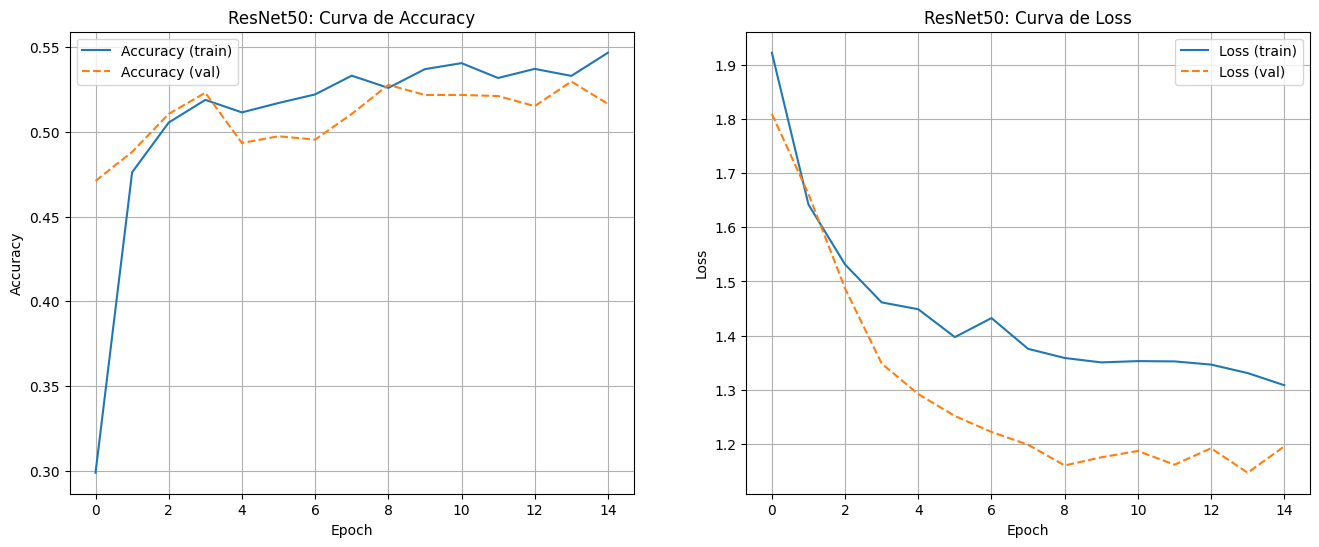

In [33]:
ig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(H.history['accuracy'], label='Accuracy (train)')
ax1.plot(H.history['val_accuracy'], label='Accuracy (val)', linestyle='--')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('ResNet50: Curva de Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(H.history['loss'], label='Loss (train)')
ax2.plot(H.history['val_loss'], label='Loss (val)', linestyle='--')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('ResNet50: Curva de Loss')
ax2.legend()
ax2.grid(True)

## **HITO 2**

In [34]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

In [35]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, Flatten

data_augmentation = Sequential([
    Input(shape=(32, 32, 3)),
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
], name="data_augmentation")

In [36]:
def process_images_for_resnet(x_ds, y_ds, augment=False):

    y = y_ds.astype(np.int64)

    X = x_ds.values.reshape((-1, 28, 28, 3))
    X = X / 255.0
    X = tf.image.resize(X, [32, 32])

    if augment:
        X = data_augmentation(X)

    X = preprocess_input(X * 255.0)

    return X, y

In [37]:
X_train, y_train = process_images_for_resnet(x_train_vision, y_train_vision, augment=True)

X_val, y_val = process_images_for_resnet(x_val_vision, y_val_vision, augment=False)

X_test, y_test = process_images_for_resnet(x_test_vision, y_test_vision, augment=False)

In [38]:
n_classes = len(np.unique(y_train))

In [39]:
base_model_resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(32, 32, 3)
)
base_model_resnet.trainable = False

model_extractor = Sequential([
    base_model_resnet,
    GlobalAveragePooling2D()
])

embeddings_train = model_extractor.predict(X_train)
embeddings_val = model_extractor.predict(X_val)
embeddings_test = model_extractor.predict(X_test)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step


In [40]:
base_model_resnet.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [130]:
classifier = Sequential([
    Input(shape=(embeddings_train.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
])

In [131]:
classifier.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,447 (521.28 KB)

 Trainable params: 133,447 (521.28 KB)

 Non-trainable params: 0 (0.00 B)

In [132]:
classifier.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [133]:
history = classifier.fit(
    embeddings_train, y_train,
    validation_data=(embeddings_val, y_val),
    epochs=10,
    batch_size=64,
    class_weight=class_weight_dict
)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.2820 - loss: 3.9243 - val_accuracy: 0.2207 - val_loss: 2.5063
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3061 - loss: 2.3696 - val_accuracy: 0.5389 - val_loss: 1.8242
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3322 - loss: 2.1530 - val_accuracy: 0.4401 - val_loss: 1.8904
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3937 - loss: 1.9384 - val_accuracy: 0.4045 - val_loss: 1.8581
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3816 - loss: 1.8591 - val_accuracy: 0.4638 - val_loss: 1.7110
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4306 - loss: 1.7446 - val_accuracy: 0.4631 - val_loss: 1.5985
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4176 - loss: 1.7152 - val_accuracy: 0.5375 - val_loss: 1.4530
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4436 - loss: 1.5930 - val_accuracy: 0

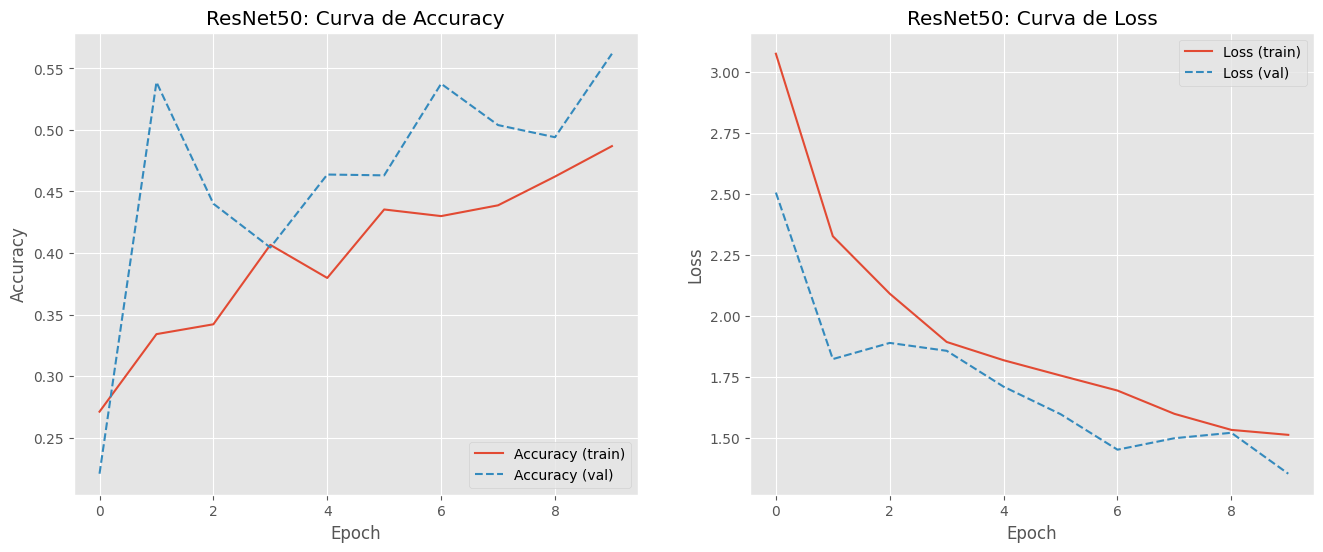

In [134]:
ig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(history.history['accuracy'], label='Accuracy (train)')
ax1.plot(history.history['val_accuracy'], label='Accuracy (val)', linestyle='--')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('ResNet50: Curva de Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(history.history['loss'], label='Loss (train)')
ax2.plot(history.history['val_loss'], label='Loss (val)', linestyle='--')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('ResNet50: Curva de Loss')
ax2.legend()
ax2.grid(True)

In [135]:
score = classifier.evaluate(embeddings_test, y_test, verbose=0)
print(f"Loss (Test): {score[0]:.4f}")
print(f"Precisión (Test): {score[1]:.4f}")

Loss (Test): 1.3141
Precisión (Test): 0.5759


In [137]:
predictions = classifier.predict(embeddings_test, batch_size=128)
print(classification_report(y_test, predictions.argmax(axis=1)))


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
              precision    recall  f1-score   support

           0       0.29      0.62      0.39        64
           1       0.24      0.37      0.29        98
           2       0.27      0.20      0.23       211
           3       0.11      0.39      0.17        28
           4       0.92      0.67      0.77      1363
           5       0.30      0.70      0.42        27
           6       0.23      0.46      0.31       199

    accuracy                           0.58      1990
   macro avg       0.34      0.49      0.37      1990
weighted avg       0.71      0.58      0.62      1990



# **Fine Tuning**

In [138]:
base_model_resnet.trainable = True

for layer in base_model_resnet.layers:
    if not layer.name.startswith('conv3'):
        layer.trainable = False

In [139]:
x = base_model_resnet.output

x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(7, activation='softmax')(x)

ft_model = Model(inputs=base_model_resnet.input, outputs=predictions)

In [140]:
ft_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [141]:
history = ft_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    class_weight=class_weight_dict
)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 230ms/step - accuracy: 0.2285 - loss: 3.4167 - val_accuracy: 0.2885 - val_loss: 1.9602
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.2675 - loss: 2.0059 - val_accuracy: 0.4433 - val_loss: 1.5871
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3939 - loss: 1.8122 - val_accuracy: 0.4532 - val_loss: 1.5904
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3816 - loss: 1.7073 - val_accuracy: 0.4460 - val_loss: 1.4842
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3976 - loss: 1.7581 - val_accuracy: 0.4526 - val_loss: 1.5551
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4250 - loss: 1.6418 - val_accuracy: 0.4816 - val_loss: 1.4850
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4396 - loss: 1.5874 - val_accuracy: 0.4993 - val_loss: 1.3813
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4467 - loss: 1.4169 - val_a

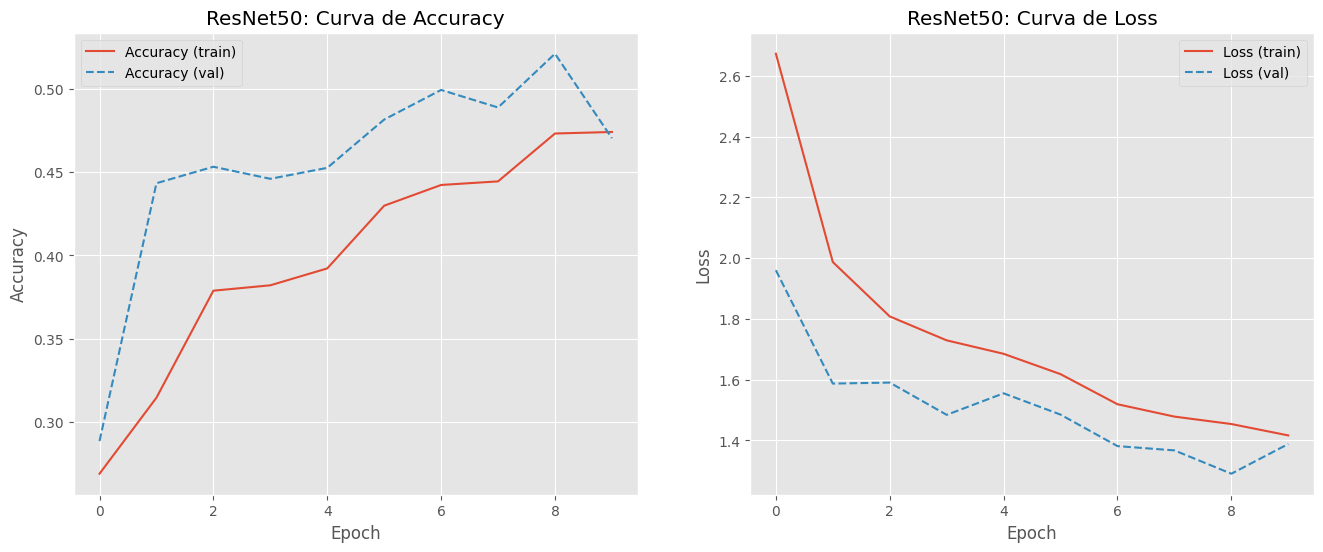

In [142]:
ig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(history.history['accuracy'], label='Accuracy (train)')
ax1.plot(history.history['val_accuracy'], label='Accuracy (val)', linestyle='--')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('ResNet50: Curva de Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(history.history['loss'], label='Loss (train)')
ax2.plot(history.history['val_loss'], label='Loss (val)', linestyle='--')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('ResNet50: Curva de Loss')
ax2.legend()
ax2.grid(True)

In [145]:
score = ft_model.evaluate(X_test, y_test, verbose=0)
print(f"Loss (Test): {score[0]:.4f}")
print(f"Precisión (Test): {score[1]:.4f}")

Loss (Test): 1.3416
Precisión (Test): 0.4804


In [146]:
predictions = ft_model.predict(X_test, batch_size=128)
print(classification_report(y_test, predictions.argmax(axis=1)))

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 306ms/step
              precision    recall  f1-score   support

           0       0.22      0.59      0.32        64
           1       0.30      0.23      0.26        98
           2       0.31      0.25      0.28       211
           3       0.09      0.32      0.14        28
           4       0.96      0.50      0.66      1363
           5       0.17      0.74      0.27        27
           6       0.20      0.64      0.30       199

    accuracy                           0.48      1990
   macro avg       0.32      0.47      0.32      1990
weighted avg       0.74      0.48      0.54      1990



## **HITO 3 y 4 - Late Fusion y Early Fusion**

In [75]:
from tensorflow.keras.layers import Concatenate

In [112]:
tabular_input_shape = (23,)
vision_input_shape = (32, 32, 3)
vision_input = Input(shape=(32, 32, 3), name="vision_input")

In [113]:
embeddings = model_extractor(vision_input)
vision_pred = classifier(embeddings)
vision_model = Model(inputs=vision_input, outputs=vision_pred, name="vision_model")
vision_model.summary()

Model: "vision_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vision_input (InputLayer)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 7)              │       133,447 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,721,159 (90.49 MB)

 Trainable params: 133,447 (521.28 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [114]:
tabular_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 32)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tabular_features (Dense)        │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,079 (144.84 KB)

 Trainable params: 12,295 (48.03 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 24,592 (96.07 KB)

In [115]:
def build_late_fusion_model():

    tabular_input = Input(shape=tabular_input_shape, name="tabular_input")
    vision_input = Input(shape=vision_input_shape, name="vision_input")

    tabular_pred = tabular_model(tabular_input)
    vision_pred = vision_model(vision_input)

    merged = Concatenate()([tabular_pred, vision_pred])
    output = Dense(7, activation="softmax", name="final_output")(merged)

    late_fusion_model = Model(inputs=[tabular_input, vision_input], outputs=output)
    return late_fusion_model

lf_model = build_late_fusion_model()
lf_model.summary()

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tabular_input       │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_input        │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 7)         │     12,487 │ tabular_input[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_model        │ (None, 7)         │ 23,721,159 │ vision_input[0][… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 14)        │          0 │ sequential_2[1][… │
│ (Concatenate)       │                   │            │ vision_model[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 7)         │        105 │ concatenate_3[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,733,751 (90.54 MB)

 Trainable params: 145,847 (569.71 KB)

 Non-trainable params: 23,587,904 (89.98 MB)

In [147]:
def build_early_fusion_model():

    tabular_input = Input(shape=tabular_input_shape, name="tabular_input")
    vision_input = Input(shape=vision_input_shape, name="vision_input")

    vision_features = model_extractor(vision_input)

    dense_layer_0 = tabular_model.get_layer('dense_6')
    dense_layer_1 = tabular_model.get_layer('dense_7')
    features_layer = tabular_model.get_layer('tabular_features')

    x_tab = dense_layer_0(tabular_input)
    x_tab = dense_layer_1(x_tab)
    tabular_features = features_layer(x_tab)

    tabular_proj = Dense(64, activation="relu", name="tabular_projection")(tabular_features)
    vision_proj = Dense(64, activation="relu", name="vision_projection")(vision_features)

    merged = Concatenate()([tabular_features, vision_features])

    x = Dense(128, activation="relu")(merged)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    output = Dense(7, activation="softmax", name="final_output")(x)

    early_fusion_model = Model(inputs=[tabular_input, vision_input], outputs=output)
    return early_fusion_model

ef_model = build_early_fusion_model()
ef_model.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tabular_input       │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │        768 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      2,112 │ dense_6[10][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_input        │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_features    │ (None, 128)       │      8,320 │ dense_7[7][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 2048)      │ 23,587,712 │ vision_input[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 2176)      │          0 │ tabular_features… │
│ (Concatenate)       │                   │            │ sequential_3[5][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 128)       │    278,656 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_38[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 64)        │      8,256 │ dropout_27[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_39[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 7)         │        455 │ dropout_28[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,887,047 (91.12 MB)

 Trainable params: 298,951 (1.14 MB)

 Non-trainable params: 23,588,096 (89.98 MB)

In [116]:
lf_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [117]:
train_inputs = {"tabular_input": x_train_tab, "vision_input": X_train}
val_inputs = {"tabular_input": x_val_tab, "vision_input": X_val}
test_inputs = {"tabular_input": x_test_tab, "vision_input": X_test}

In [118]:
history_lf = lf_model.fit(
    train_inputs,
    y_train_vision,
    validation_data=(val_inputs, y_val_vision),
    epochs=10,
    batch_size=64,
    class_weight=class_weight_dict
)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 29s 140ms/step - accuracy: 0.3342 - loss: 1.8966 - val_accuracy: 0.5408 - val_loss: 1.5479
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5188 - loss: 1.7467 - val_accuracy: 0.4091 - val_loss: 1.6736
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5480 - loss: 1.6621 - val_accuracy: 0.5468 - val_loss: 1.6333
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5835 - loss: 1.5842 - val_accuracy: 0.5863 - val_loss: 1.3943
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6136 - loss: 1.5369 - val_accuracy: 0.5711 - val_loss: 1.4486
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6012 - loss: 1.5472 - val_accuracy: 0.5744 - val_loss: 1.3271
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6015 - loss: 1.3789 - val_accuracy: 0.5573 - val_loss: 1.4210
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6076 - loss: 1.4107 - val_ac

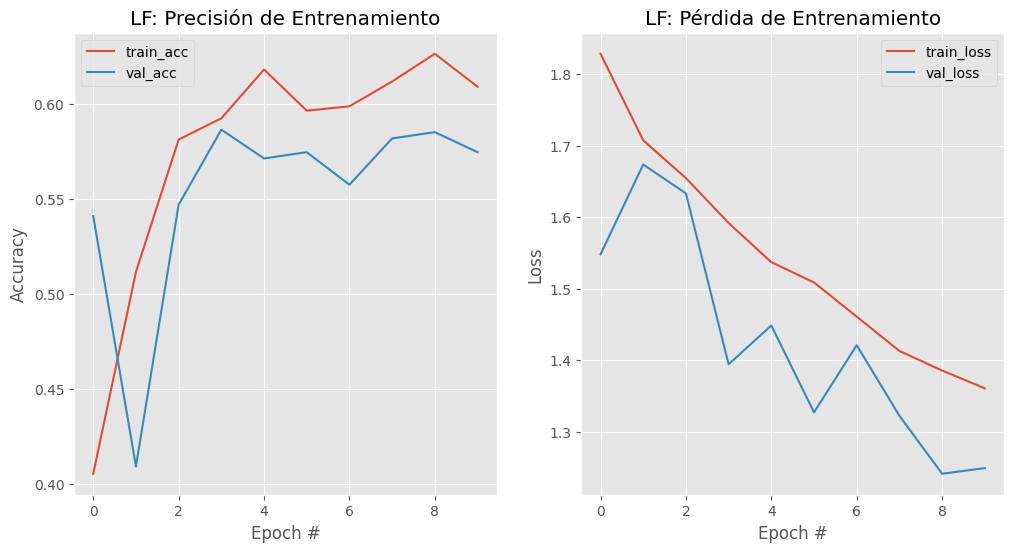

In [120]:
plt.style.use("ggplot")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(np.arange(0, 10), history_lf.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 10), history_lf.history["val_accuracy"], label="val_acc")
plt.title("LF: Precisión de Entrenamiento")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, 10), history_lf.history["loss"], label="train_loss")
plt.plot(np.arange(0, 10), history_lf.history["val_loss"], label="val_loss")
plt.title("LF: Pérdida de Entrenamiento")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [121]:
test_inputs = {"tabular_input": x_test_tab, "vision_input": X_test}

score_lf = lf_model.evaluate(
    test_inputs,
    y_test_vision,
    verbose=0
)

print(f"Loss (Test): {score_lf[0]:.4f}")
print(f"Precisión (Test): {score_lf[1]:.4f}")

Loss (Test): 1.2489
Precisión (Test): 0.5724


In [122]:
predictions_lf = lf_model.predict(test_inputs)

y_pred_labels_lf = np.argmax(predictions_lf, axis=1)

y_true_labels = y_test_vision

print(classification_report(y_true_labels, y_pred_labels_lf))

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step
              precision    recall  f1-score   support

           0       0.25      0.67      0.36        64
           1       0.29      0.40      0.33        98
           2       0.27      0.25      0.26       211
           3       0.23      0.61      0.33        28
           4       0.98      0.62      0.76      1363
           5       0.30      0.70      0.42        27
           6       0.24      0.59      0.35       199

    accuracy                           0.57      1990
   macro avg       0.37      0.55      0.40      1990
weighted avg       0.75      0.57      0.62      1990



In [148]:
ef_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

train_inputs = {"tabular_input": x_train_tab, "vision_input": X_train}
val_inputs = {"tabular_input": x_val_tab, "vision_input": X_val}
test_inputs = {"tabular_input": x_test_tab, "vision_input": X_test}

In [149]:
history_ef = ef_model.fit(
    train_inputs,
    y_train_vision,
    validation_data=(val_inputs, y_val_vision),
    epochs=15,
    batch_size=32,
    class_weight=class_weight_dict
)

Epoch 1/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - accuracy: 0.2787 - loss: 2.0649 - val_accuracy: 0.5823 - val_loss: 1.2954
Epoch 2/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5132 - loss: 1.3874 - val_accuracy: 0.6080 - val_loss: 1.3248
Epoch 3/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5887 - loss: 1.1291 - val_accuracy: 0.5692 - val_loss: 1.2907
Epoch 4/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6144 - loss: 1.0660 - val_accuracy: 0.6436 - val_loss: 1.0269
Epoch 5/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6341 - loss: 0.9622 - val_accuracy: 0.6528 - val_loss: 1.0156
Epoch 6/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6696 - loss: 0.9026 - val_accuracy: 0.6726 - val_loss: 0.8897
Epoch 7/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6704 - loss: 0.8702 - val_accuracy: 0.6548 - val_loss: 0.9491
Epoch 8/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7039 - loss: 0.7747 - val_acc

In [150]:
score_ef = ef_model.evaluate(
    test_inputs,
    y_test_vision,
    verbose=0
)
print(f"Loss (Test EF): {score_ef[0]:.4f}")
print(f"Precisión (Test EF): {score_ef[1]:.4f}")

Loss (Test EF): 0.9252
Precisión (Test EF): 0.6688


In [151]:
predictions_ef = ef_model.predict(test_inputs)
y_pred_labels_ef = np.argmax(predictions_ef, axis=1)
y_true_labels = y_test_vision

print(classification_report(y_true_labels, y_pred_labels_ef))

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step
              precision    recall  f1-score   support

           0       0.25      0.45      0.32        64
           1       0.41      0.48      0.44        98
           2       0.47      0.58      0.52       211
           3       0.19      0.61      0.29        28
           4       0.97      0.73      0.83      1363
           5       0.31      0.59      0.41        27
           6       0.33      0.56      0.41       199

    accuracy                           0.67      1990
   macro avg       0.42      0.57      0.46      1990
weighted avg       0.78      0.67      0.71      1990



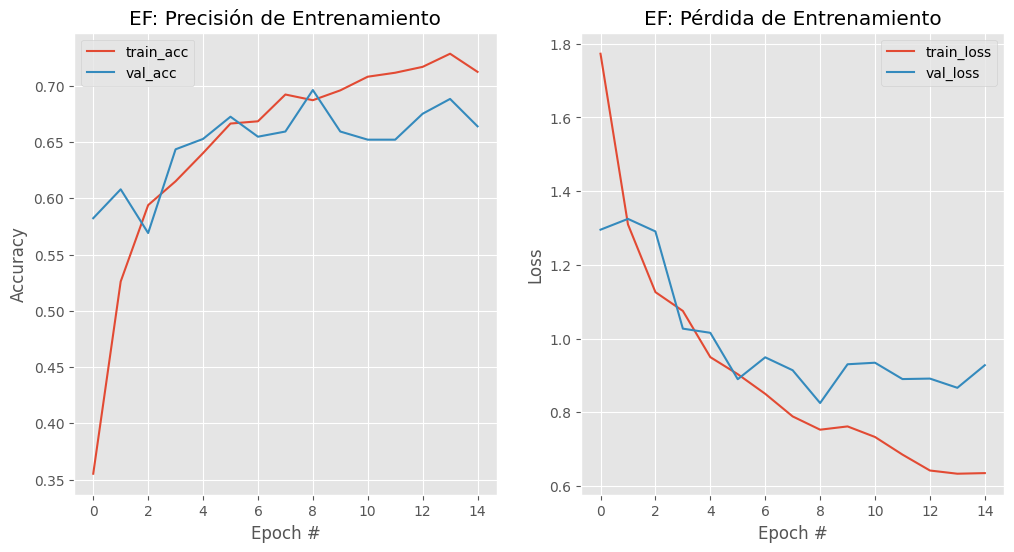

In [152]:
plt.style.use("ggplot")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(np.arange(0, 15), history_ef.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 15), history_ef.history["val_accuracy"], label="val_acc")
plt.title("EF: Precisión de Entrenamiento")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, 15), history_ef.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), history_ef.history["val_loss"], label="val_loss")
plt.title("EF: Pérdida de Entrenamiento")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

plt.show()

# **Resultados**

##Modelo 1:

En el primer modelo se utilizaron solo los datos tabulares, obteniendo un accuracy de ~51%, aunque la información más relevante se encuentra en el informe de clasificación revelando que el modelo sufría de un alto sesgo. El modelo principalmente aprendió a predecir la clase 4, sacrificando casi por completo al resto. Las puntuaciones F1 para las clases minoritarias fueron muy bajas, resultando en un promedio macro F1 de solo 0.28.

##Modelo 2:

El segundo modelo utiliza solo los datos de imagen, procesándolos con un modelo ResNet50 para extraer características mediante Transfer Learning, para posteriormente hacer Fine Tuning.

Utilizando transfer learning, el modelo alcanza una precisión comparable al rendimiento del modelo tabular, aunque mejora todas las métricas de este.

Sobre el modelo de Fine-Tuning, donde se reentrenaron las capas finales de ResNet50, los resultados son algo pobres para lo que se podía esperar, siendo inferiores al modelo offline.

##Modelo 3 y 4:

###Late Fusion
Este modelo combina las predicciones de los dos modelos (tabular y visión) ya entrenados. Este enfoque logra mejorar el resultado, alcanzando una precisión en train de ~57.2%.

El informe de clasificación muestra una mejora notable en el recall de las clases minoritarias (ej. 0.67 para la clase 0, 0.70 para la 5). Sin embargo, la precisión siguió siendo muy baja (promedio macro F1 de 0.40).

###Early Fusion
Este modelo extrae los embeddings de ambas ramas y los concatena. Debido a que hay 128 características tabulares y 2048 de visión, las proyectamos para que ambas tengan el mismo peso para nuestro modelo, ya que si no se le prestaría mucha importancia a las de visión y se podrían ignorar las tabulares. Este modelo es el que sin duda presenta los mejores resultados en todas las métricas, siendo no sólo el modelo con mas precisión, sino que es el modelo más equilibrado, teniendo una alta precisión para la clase mayoritaria y logrando una mejora significativa respecto a las minoritarias.

#**Conclusiones**

Se puede concluir que la early fusion es la estrategia que aporta mejores resultados, permitiendo que el clasificador encuentre mejores patrones para hallar clasificaciones más acertadas y equilibradas.